<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/ensemble-methods-for-machine-learning/02-homogeneous-parallel-ensembles/01_bagging_bootstrap_aggregating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bagging: Bootstrap aggregating

Bagging is the most basic homogeneous parallel ensemble method we can construct.

Bagging uses the same base machine-learning algorithm to train base estimators. 

So how can we get multiple base estimators from a single data set and a single learning
algorithm, let alone diversity? 

This comes by training base estimators on replicates of the
data set. Bagging consists of two steps:

1. During training, bootstrap sampling, or sampling with replacement, is used to generate replicates of the training data set that are different from each other but drawn from the original data set. This ensures that base learners trained on each of the replicates are also different from each other.

2. During prediction, model aggregation is used to combine the predictions of
the individual base learners into one ensemble prediction. For classification
tasks, we can combine individual predictions using majority voting. For regression tasks, we can combine individual predictions using simple averaging.

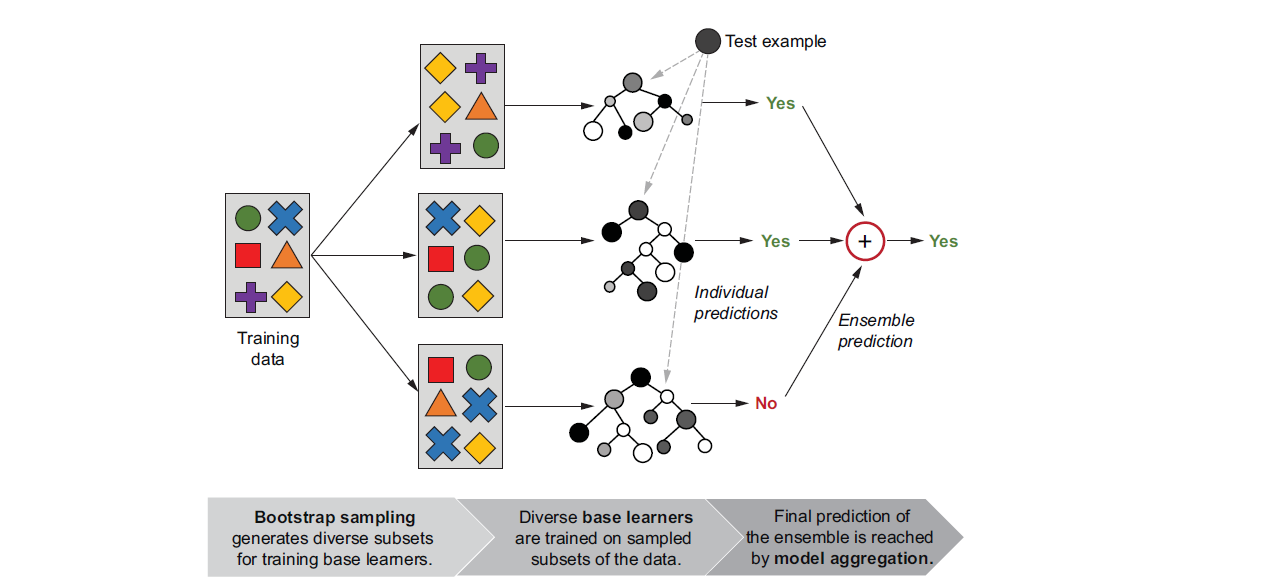

##Setup

In [ ]:
!wget https://github.com/gkunapuli/ensemble-methods-notebooks/raw/master/plot_utils.py

In [ ]:
import time
import os
import pickle
import numpy as np

from scipy.stats import mode

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from plot_utils import plot_2d_data, plot_2d_classifier

%matplotlib inline
import matplotlib.pyplot as plt

##Resampling and model aggregation

Bagging is the most basic homogeneous parallel ensemble method we can construct.

Bagging uses the same base machine-learning algorithm to train base estimators. 

So how can we get multiple base estimators from a single data set and a single learning
algorithm, let alone diversity? 

This comes by training base estimators on replicates of the
data set. Bagging consists of two steps: